In [3]:
import torch
import torchsde

batch_size, state_size, brownian_size = 32, 3, 2
t_size = 20

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(state_size, 
                                  state_size)
        self.sigma = torch.nn.Linear(state_size, 
                                     state_size * brownian_size)

    # Drift
    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(batch_size, 
                                  state_size, 
                                  brownian_size)

sde = SDE()
y0 = torch.full((batch_size, state_size), 0.1)
ts = torch.linspace(0, 1, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, y0, ts)


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import xarray

import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwf.opendata import Client

c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


In [4]:
plt.plot(ys[:,0,0])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

: 

In [32]:
client = Client(source="ecmwf")

client.retrieve(
    time=0,
    stream="enfo",
    type=['cf'],
    param=['u','v'],
    step=[0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,78,81,84,87,90,93,96,99,102,105,108,111,114,117,120],
    levelist = 925,
    target="data.grib6",
)

<multiple>:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

# ERA5 Data

[[[ 9.205143    9.112887    9.071489   ...  8.364402    7.984094
    7.642229  ]
  [ 9.517444    9.3882265   9.28428    ...  8.300476    7.906915
    7.5389247 ]
  [ 9.965678    9.812309    9.615565   ...  8.110103    7.6562715
    7.1694245 ]
  ...
  [ 3.3602154   3.2731552   3.2686858  ...  1.0407048   0.84154177
    0.5539943 ]
  [ 3.257956    3.200339    3.0236487  ...  0.8951459   1.0790251
    1.0779116 ]
  [ 2.8235126   2.6269243   2.3865619  ...  0.7247255   1.0399975
    1.3415747 ]]

 [[10.54115    10.304861   10.014737   ...  8.702614    8.242794
    7.7938924 ]
  [11.04068    10.861573   10.501436   ...  8.81585     8.343879
    7.826096  ]
  [11.607791   11.535241   11.165502   ...  8.643271    8.1434145
    7.5359173 ]
  ...
  [ 3.523604    3.3420477   3.2509992  ...  1.0682285   0.84648895
    0.5592244 ]
  [ 3.4119747   3.248493    3.0030239  ...  0.9144973   1.1182313
    1.0937926 ]
  [ 2.946015    2.7070587   2.4436555  ...  0.6619326   1.061256
    1.3866563 ]]

 [[

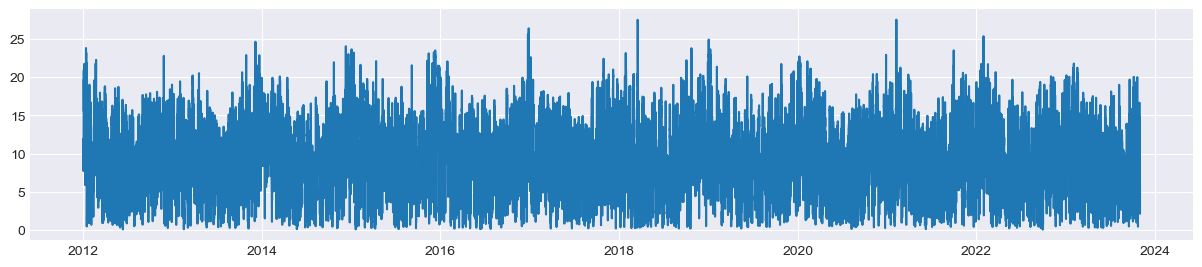

In [153]:
#f1=xr.open_dataset('dataset_2012-2014.nc')
#f2=xr.open_dataset('dataset_2015-2017.nc')
#f3=xr.open_dataset('dataset_2018-2020.nc')
#f4=xr.open_dataset('dataset_2021-2023.nc')

#f = xr.concat([f4, f3, f2, f1], dim='time')

f = xr.open_dataset('dataset_2012-2023_1000hPa.nc')



lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u'][:,:,:,0] # u-wind at 100m height
v100 = f.variables['v'][:,:,:,0]  # v-wind at 100m height
#u10 = f.variables['u10'][:,0,:,:]  # u-wind at 10m height
#v10 = f.variables['v10'][:,0,:,:]  # v-wind at 10m height
time = f.variables['time'][:]


ws100_data = np.array(np.sqrt(u100*u100+v100*v100))


nan_idx = np.argwhere(~np.isnan(ws100_data[:,0,0])).T[0]
ws100 = ws100_data[nan_idx,:,:]
time_vec = time[nan_idx]

plt.figure(figsize = (15,3))
plt.plot(time_vec, ws100[:,2,2])

print(ws100)


(array([ 237.,  701., 1241., 1756., 1840., 1304.,  724.,  297.,   68.,
          16.]),
 array([ 0.05889867,  2.81200504,  5.56511116,  8.31821728, 11.07132435,
        13.82443047, 16.57753754, 19.3306427 , 22.08374977, 24.83685493,
        27.58996201]),
 <BarContainer object of 10 artists>)

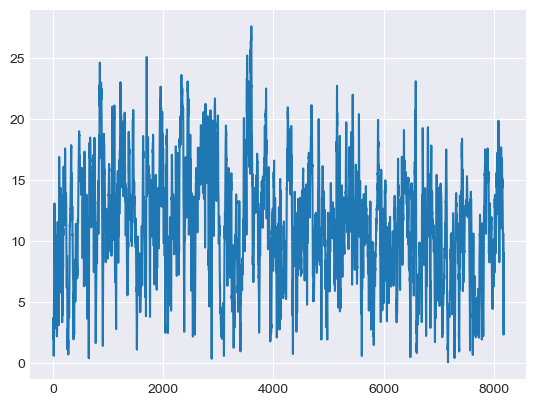

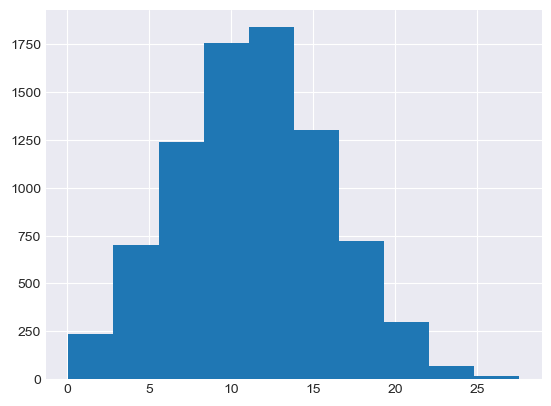

In [113]:
import pandas as pd
month_vec = pd.to_datetime(time_vec).month

dec_ind = np.where(month_vec == 12)

dec_ws100 = ws100[dec_ind,:,:]

plt.figure(0)
plt.plot(dec_ws100[0,:,0,0])


plt.figure(1)
plt.hist(dec_ws100[0,:,0,0])


In [157]:
from scipy.optimize import curve_fit 

def time_as_year_fraction(time):
    first_date=time[:][0].values 
    diff_in_sec = ((time[:][:].values-first_date)) / np.timedelta64(1, 's')
    time_frac = diff_in_sec / (365*24*60*60) #days, hours, minutes, seconds
    return time_frac
    #year = first_date.astype('datetime64[Y]').astype(int) + 1970
    #month = first_date.astype('datetime64[M]').astype(int) % 12 + 1
    #day = (first_date.astype('datetime64[D]') - first_date.astype('datetime64[M]')).astype(int) + 1

def deseasonalize_data(time, data, loc1, loc2, plot=False): #time=time_frac, data=ws100

    def sin_func(x,a,b,c,d):
        return a * np.sin(b * x + c) + d
    
    def monthly_func(x, *args):
        a = (x*365/31) #month
        b = np.full(a.shape, args[11])
        for i in range(11, 0, -1):
            b[a<i] = args[i-1]
        return b

    if loc2 is None:
        loc2 = loc1
    
    nan_idx = np.argwhere(~np.isnan(data[:,loc1,loc2])).T[0] #index of all not nan values
    xdata = time[nan_idx]
    ydata = data[nan_idx, loc1, loc2]
    time_shifted = np.copy(xdata) % 1

    popt, _ = curve_fit(monthly_func, time_shifted, ydata, p0=[1]*12)#, bounds=([-1., -1., -10., 0.], [3., 3., 10., 10.,])) #pcov, info, msg, ier: p0=[1,1,1,1], full_output=True
    ydata_deseasonalized = ydata - monthly_func(time_shifted, *popt)

    if False:
        plt.figure(figsize=(15,5))
        plt.plot(xdata, ydata, label='data')
        plt.plot(xdata, monthly_func(time_shifted, *popt), label='monthly_avg')#, label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.plot(xdata, ydata_deseasonalized, label='deseasonalized data', alpha=0.7)
        plt.xlabel('time')
        plt.ylabel('wind speed in m/s')
        plt.legend()
        plt.show()

    return ydata_deseasonalized, popt

nan_idx = np.argwhere(~np.isnan(ws100_data[:,0,0])).T[0]
wsnew = np.zeros(ws100_data[nan_idx,:,:].shape)
time_frac = time_as_year_fraction(time[nan_idx])
for i in range(wsnew.shape[1]):
    for j in range(wsnew.shape[2]):
        wsnew[:,i,j], monthly_params = deseasonalize_data(time=time_frac, data=wsnew, loc1=i, loc2=j, plot=True)



[[ 5.06642719e+02 -2.50709547e-07 -1.25920360e-06  2.60615663e-06
  -4.88856650e-07 -9.40908301e-07 -1.34910352e-06 -1.39153030e-07
   1.20885176e-06 -2.21655790e-07]
 [-2.50709547e-07  2.57537657e+02  5.66976444e-08 -1.91421939e-07
  -2.03812082e-07  6.05693995e-08 -4.16805662e-07  6.02217075e-07
   5.21906315e-07 -3.24279590e-07]
 [-1.25920360e-06  5.66976444e-08  7.08151227e+01 -1.55259975e-06
  -1.91730308e-07  4.04952198e-07 -2.55481740e-07 -2.94786873e-07
  -4.04185566e-08  5.82415416e-08]
 [ 2.60615663e-06 -1.91421939e-07 -1.55259975e-06  4.90297801e+01
   1.23608291e-05  5.61537835e-07  2.09901451e-06  2.47211627e-06
  -1.43119752e-06  1.72814076e-07]
 [-4.88856650e-07 -2.03812082e-07 -1.91730308e-07  1.23608291e-05
   4.18044917e+01  1.82175190e-06 -4.50201661e-06  1.34115641e-06
   3.34349758e-06  5.64588488e-07]
 [-9.40908301e-07  6.05693995e-08  4.04952198e-07  5.61537835e-07
   1.82175190e-06  3.49991523e+01 -1.18809351e-05  3.15189150e-06
   3.97060681e-06  7.71932656e-08

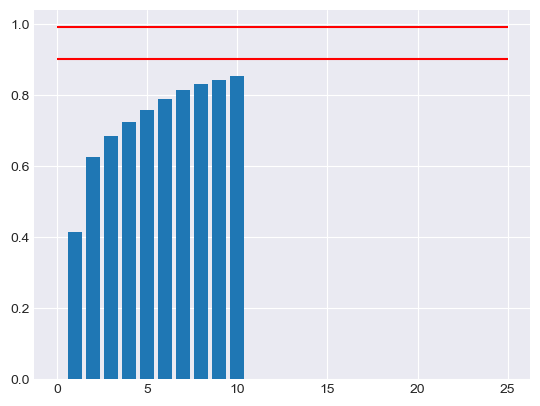

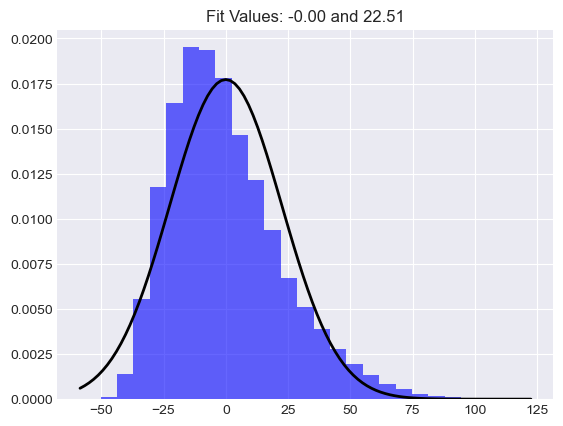

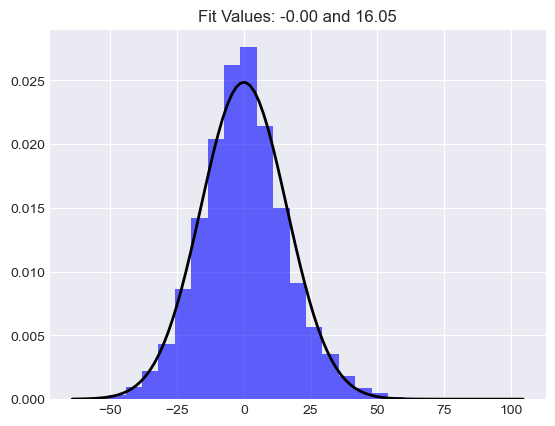

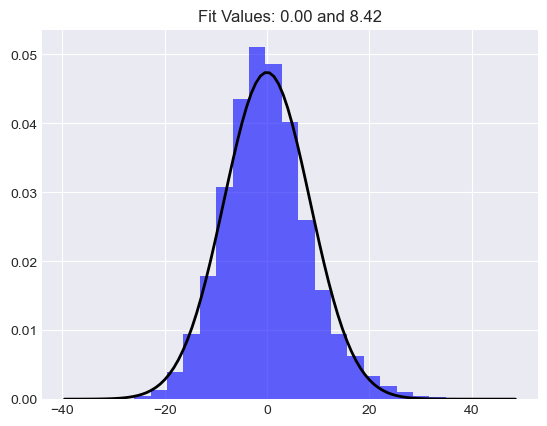

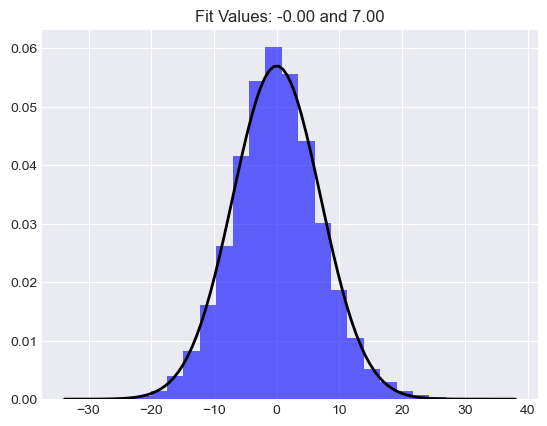

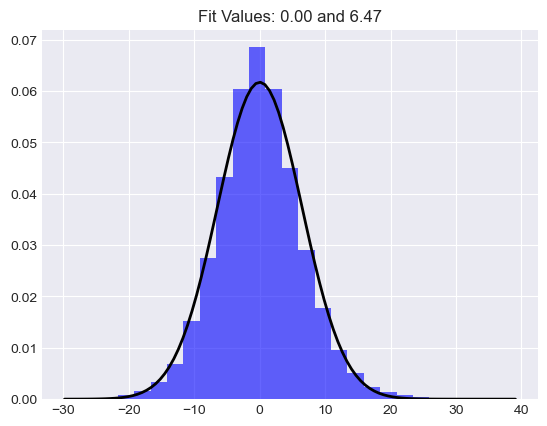

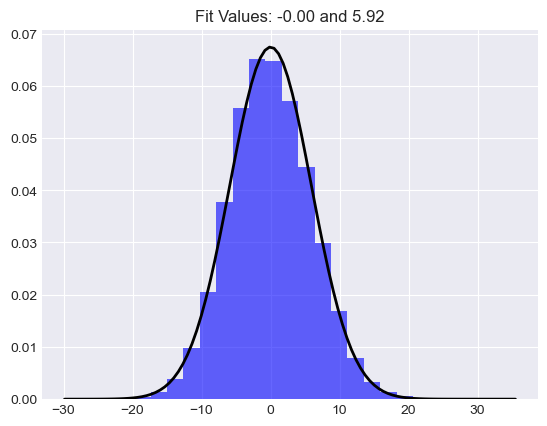

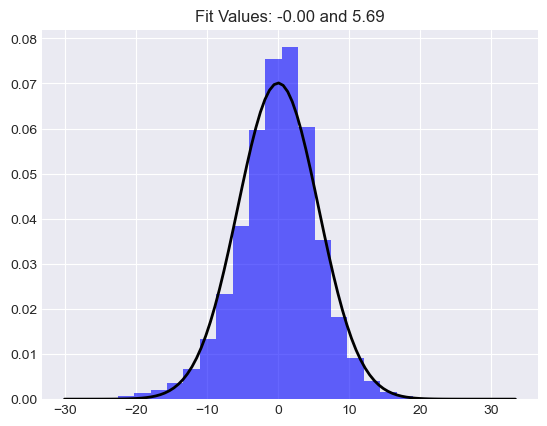

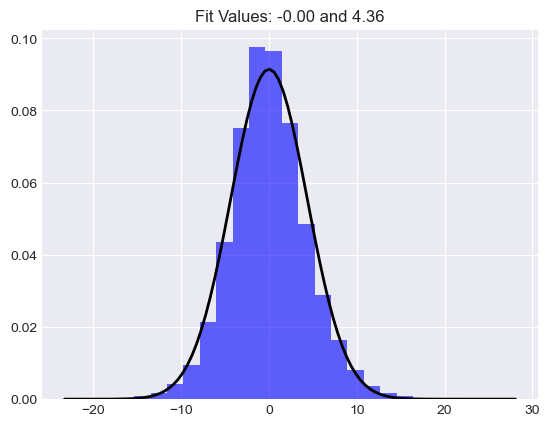

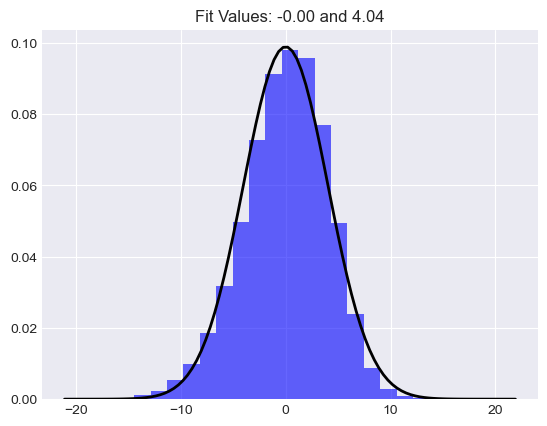

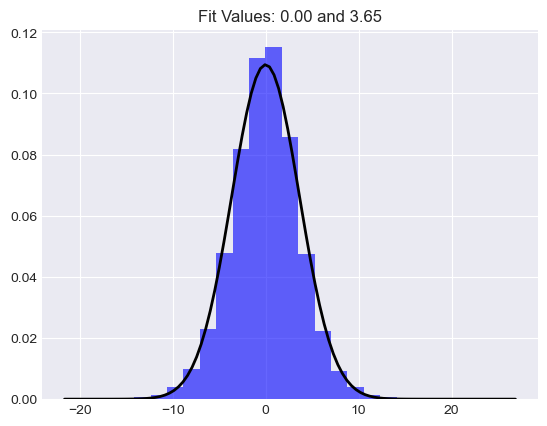

In [160]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.stats import norm 


nPCAc = 10
ws100[np.isnan(ws100)] = 0
Y = ws100[:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
pca = PCA(n_components=nPCAc)
principalComponents_ERA5 = pca.fit_transform(X)

bla = principalComponents_ERA5[:150000,0]
for j in range(1,nPCAc):
    bla = np.vstack([bla, principalComponents_ERA5[:150000,j]])       
sigq = np.cov(bla)

print(sigq)


plt.figure(1)
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 0.9,xmin= 0, xmax = 25,colors="red")
plt.hlines(y = 0.99,xmin= 0, xmax = 25,colors="red")
plt.show()

for i in range(nPCAc):

    #plt.figure(i+2, figsize=[15,3])
    #plt.plot(principalComponents_ERA5[:150000,i])

    mu, std = norm.fit(principalComponents_ERA5[:150000,i]) 
    plt.figure(i+2)
    plt.hist(principalComponents_ERA5[:150000,i], bins=25, density=True, alpha=0.6, color='b') 
    xmin, xmax = plt.xlim() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, std) 
  
    plt.plot(x, p, 'k', linewidth=2) 
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
    plt.title(title) 

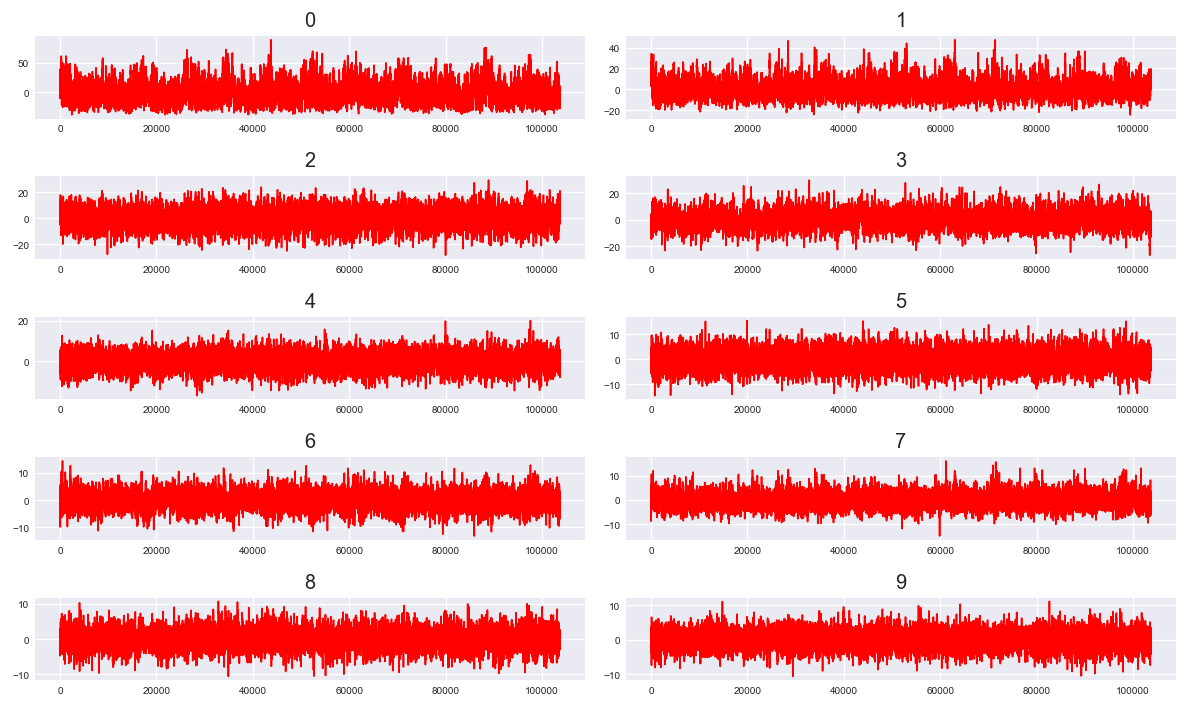

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# For time series analysis
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# For data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame(data = principalComponents_ERA5[:150000,:])

tickers = df.columns

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();




In [70]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    #df.columns = [var + '_x' for var in variables]
    #df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

KeyboardInterrupt: 

In [45]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
0      ::  4056.62   > 12.3212   =>   True
1      ::  1388.29   > 4.1296    =>   True


In [131]:
nobs = 3*24
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(103656, 10)
(72, 10)


In [132]:
model = VAR(df_train)
bla = model.select_order(30)
print(bla)
model_fitted = model.fit(26)
model_fitted.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 30, BIC -> 26, FPE -> 30, HQIC ->  27>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Jan, 2024
Time:                     14:17:25
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -3.89466
Nobs:                     103630.    HQIC:                  -4.06228
Log likelihood:      -1.25357e+06    FPE:                  0.0160004
AIC:                     -4.13514    Det(Omega_mle):       0.0156029
--------------------------------------------------------------------
Results for equation 0
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000013         0.004353            0.003           0.998
L1.0          1.585849         0.003225          491.706           0.000
L1.1         -0.000554         0.004364           -0.127           0.899
L1.2         -0.127959 

In [133]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

print(out)

#for col, val in zip(df.columns, out):
#    print(adjust(col), ':', round(val, 2))

[2.01602518 2.01221624 2.00605899 2.00344205 2.00098597 1.99979102
 1.99953384 1.99943845 1.99953379 2.00081536]


In [134]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:])
df_forecast

26


,0,1,2,3,4,5,6,7,8,9
103656,-7.933929,8.749360,0.612189,-9.953500,2.854041,-3.045986,-2.842498,-3.193498,2.411183,0.271446
103657,-6.533843,9.151046,0.631319,-9.811018,2.879706,-2.948592,-2.372650,-3.035805,1.935770,0.127617
103658,-5.415825,9.335577,0.628012,-9.729824,2.750213,-2.829496,-2.050030,-2.892606,1.444092,-0.002659
103659,-4.786635,9.350373,0.636065,-9.678671,2.539958,-2.538184,-1.815084,-2.812135,0.961294,-0.036219
103660,-4.032530,9.683777,0.941240,-9.662759,2.179437,-2.278572,-1.557670,-2.714992,0.591649,-0.032083
...,...,...,...,...,...,...,...,...,...,...
103723,1.297100,0.974713,-0.042137,-1.272105,0.276141,0.016899,0.019497,-0.162529,-0.207833,0.103418
103724,1.345382,0.990608,-0.032468,-1.211127,0.252673,0.004121,0.008827,-0.144970,-0.199369,0.093684
103725,1.357359,1.003083,-0.020146,-1.166009,0.243660,-0.004490,-0.010603,-0.139899,-0.189088,0.092662
103726,1.063382,0.762372,-0.185784,-1.228010,0.275033,0.003449,-0.011417,-0.129975,-0.206445,0.071514


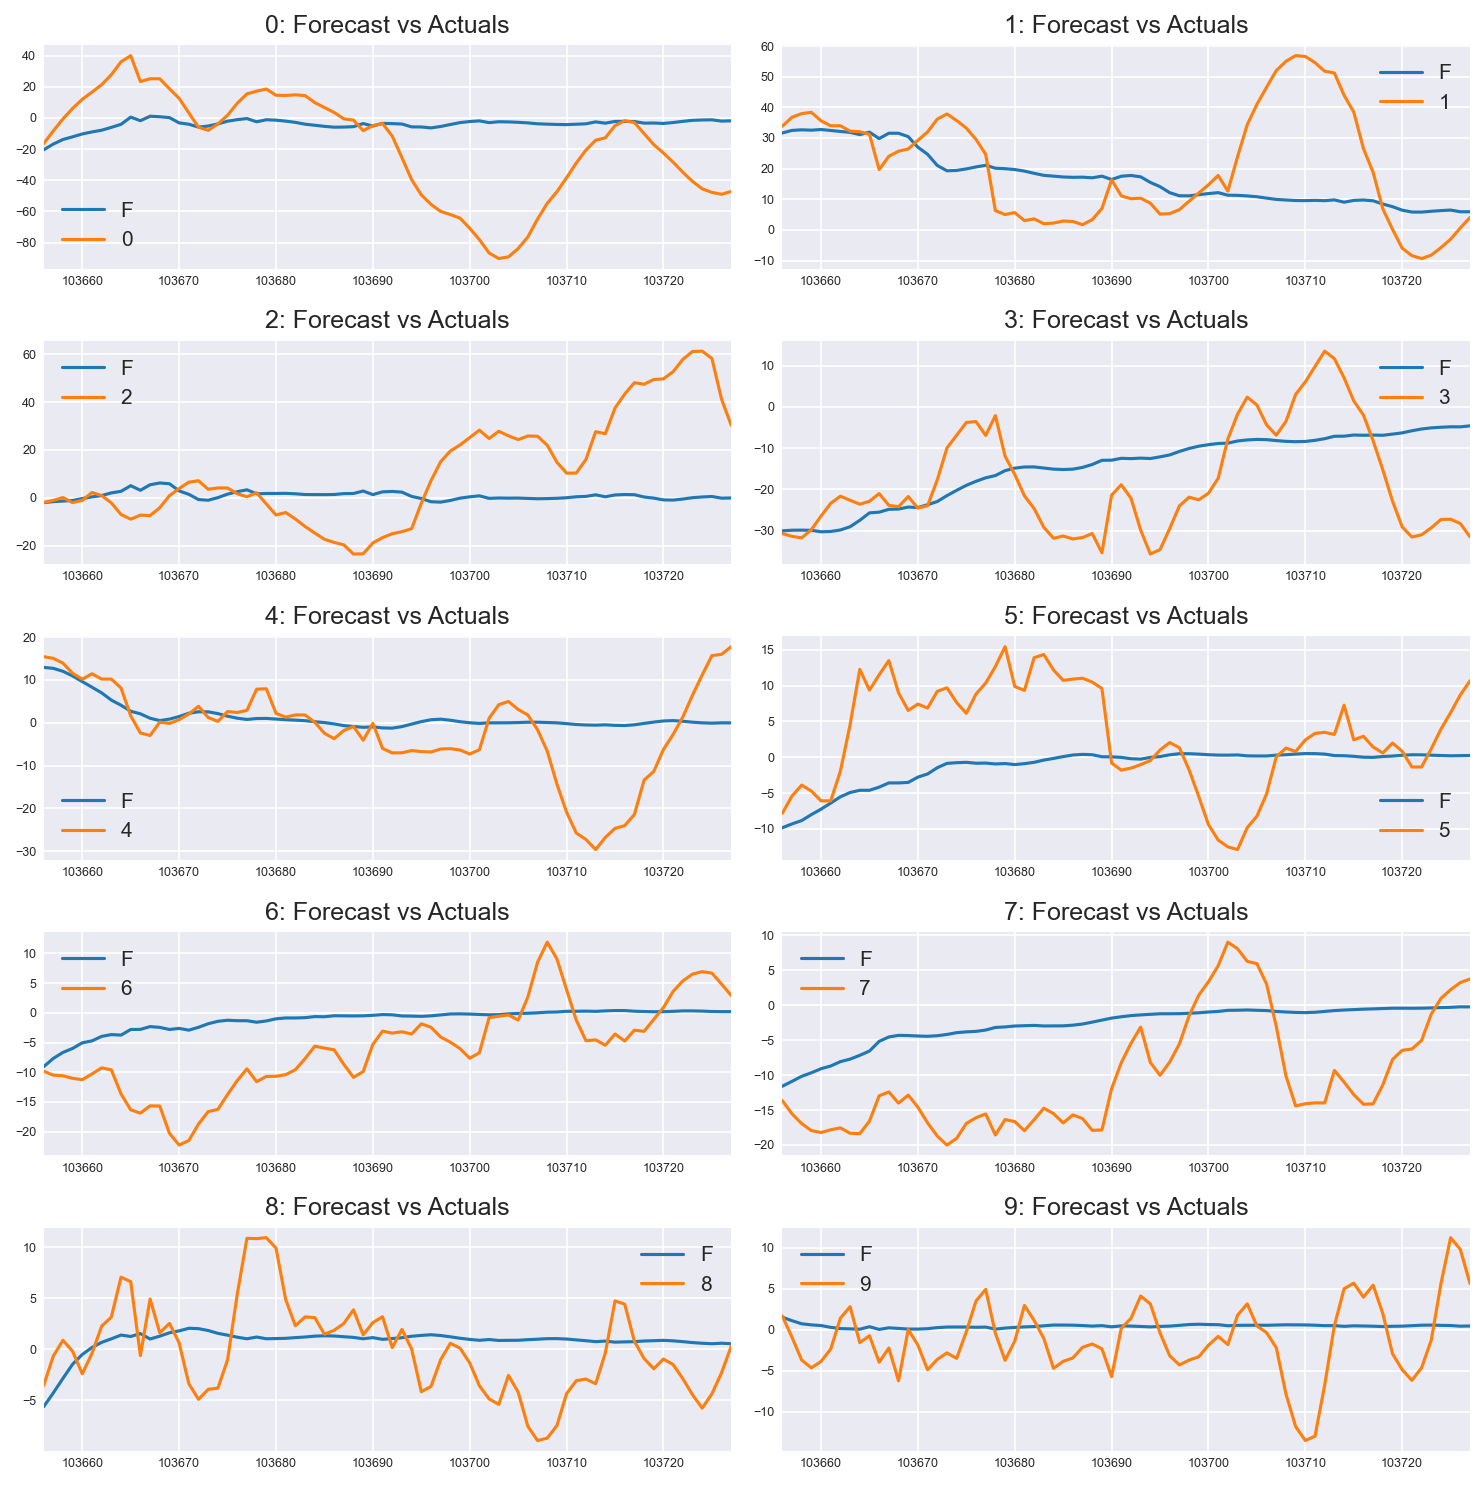

In [107]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col].plot(label = 'F',legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(str(col) + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# ECMWF Ensemble Data


In [4]:
data_24_cf = xarray.open_dataset('20231224_0h_data.grib2', engine='cfgrib',filter_by_keys={'dataType': 'cf'})
data_24_pf = xarray.open_dataset('20231224_0h_data.grib2', engine='cfgrib',filter_by_keys={'dataType': 'pf'})
data_25_cf = xarray.open_dataset('20231225_0h_data.grib2', engine='cfgrib',filter_by_keys={'dataType': 'cf'})
data_25_pf = xarray.open_dataset('20231225_0h_data.grib2', engine='cfgrib',filter_by_keys={'dataType': 'pf'})
data_26_cf = xarray.open_dataset('20231226_0h_data.grib2', engine='cfgrib',filter_by_keys={'dataType': 'cf'})
data_26_pf = xarray.open_dataset('20231226_0h_data.grib2', engine='cfgrib',filter_by_keys={'dataType': 'pf'})

In [8]:
print(data_24_cf)

<xarray.Dataset>
Dimensions:        (step: 31, isobaricInhPa: 3, latitude: 451, longitude: 900)
Coordinates:
    number         int32 ...
    time           datetime64[ns] ...
  * step           (step) timedelta64[ns] 0 days 00:00:00 ... 3 days 18:00:00
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 925.0 850.0
  * latitude       (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude      (longitude) float64 -180.0 -179.6 -179.2 ... 179.2 179.6
    valid_time     (step) datetime64[ns] ...
Data variables:
    u              (step, isobaricInhPa, latitude, longitude) float32 ...
    v              (step, isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:    

In [11]:
lons_ecmwf = np.array(data_24_cf.variables['longitude'][:])  # longitude 900
lats_ecmwf = np.array(data_24_cf.variables['latitude'][:])  # latitude 451
time_24 = np.array(data_24_cf.variables['step'])
u_24 = data_24_cf.variables['u'] #4, lons, lats
v_24 = data_24_cf.variables['v'] #4, lons, lats

In [13]:
print(u_24)

<xarray.Variable (step: 31, isobaricInhPa: 3, latitude: 451, longitude: 900)>
[37748700 values with dtype=float32]
Attributes: (12/30)
    GRIB_paramId:                             131
    GRIB_dataType:                            cf
    GRIB_numberOfPoints:                      405900
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           u
    GRIB_totalNumber:                         51
    GRIB_units:                               m s**-1
    long_name:                                U component of wind
    units:                                    m s**-1
    standard_name:                            eastward_wind


In [17]:

data = xarray.open_dataset('data.grib', engine='cfgrib')
data_cf = xarray.open_dataset('data.grib2', engine='cfgrib')

print(data)
#data.to_netcdf('netcdf_file.nc')

lons_ecmwf = np.array(data.variables['longitude'][:])  # longitude 900
lats_ecmwf = np.array(data.variables['latitude'][:])  # latitude 451
time_ecmwf = np.array(data.variables['step'])
u_ecmwf = np.array(data.variables['u']) #4, lons, lats
v_ecmwf = np.array(data.variables['v']) #4, lons, lats

u_ecmwf_cf = np.array(data_cf.variables['u']) #4, lons, lats
v_ecmwf_cf = np.array(data_cf.variables['v']) #4, lons, lats
#ws_ecmwf = np.array(np.sqrt(u_ecmwf*u_ecmwf+v_ecmwf*v_ecmwf))

Ignoring index file 'data.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:        (step: 11, latitude: 451, longitude: 900)
Coordinates:
    number         int32 ...
    time           datetime64[ns] ...
  * step           (step) timedelta64[ns] 00:00:00 03:00:00 ... 1 days 06:00:00
    isobaricInhPa  float64 ...
  * latitude       (latitude) float64 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * longitude      (longitude) float64 -180.0 -179.6 -179.2 ... 179.2 179.6
    valid_time     (step) datetime64[ns] ...
Data variables:
    u              (step, latitude, longitude) float32 ...
    v              (step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-01-21T10:30 GRIB to CDM+CF via cfgrib-0.9.1...


In [18]:
print(np.array(data.variables['valid_time']))

['2023-12-25T00:00:00.000000000' '2023-12-25T03:00:00.000000000'
 '2023-12-25T06:00:00.000000000' '2023-12-25T09:00:00.000000000'
 '2023-12-25T12:00:00.000000000' '2023-12-25T15:00:00.000000000'
 '2023-12-25T18:00:00.000000000' '2023-12-25T21:00:00.000000000'
 '2023-12-26T00:00:00.000000000' '2023-12-26T03:00:00.000000000'
 '2023-12-26T06:00:00.000000000']


In [34]:
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwf.opendata import Client
data = ecdata.read("data.grib2")
data.describe('u')

shortName,u
name,U component of wind
paramId,131
units,m s**-1
typeOfLevel,isobaricInhPa
level,925
date,20231225
time,0
step,"0,3,6,9,12,15,18,21,24,27,30"
number,"1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,32,33,34,35,36,37,38,39,4,40,41,42,43,44,45,46,47,48,49,5,50,6,7,8,9"
class,od


In [35]:
u = data.select(shortName='u', step=3).sort()
v = data.select(shortName='v', step=3).sort()

speed = ecdata.speed(u,v)
speed.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
ws,isobaricInhPa,925,20231225,0,3,"1,10,...",10,od,enfo,pf,0001


In [43]:
mask = ecdata.Fieldset()
for number in range(51):
    speed_n = speed.select(number = number,)
    m = (speed_n > 10) 
    mask.append(m)

prob = (ecdata.mean(mask))*100

print(prob)

Fieldset (1 field)


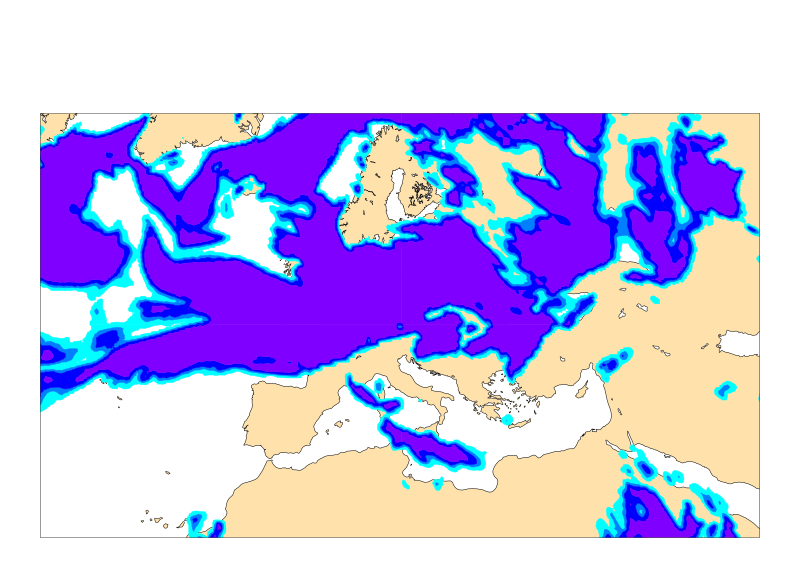

In [48]:
fig = GeoMap(area_name='europe')

fig.coastlines(land_colour="cream",resolution="medium")
fig.contour_shaded(prob, style="probability_blue")
#fig.coastlines(resolution="medium")
#fig.gridlines()

#fig.legend()
#fig.title(['bla'])

fig.show()

In [51]:
ws_ecmwf = np.array(np.sqrt(u_ecmwf*u_ecmwf+v_ecmwf*v_ecmwf))
ws_ecmwf_cf = np.array(np.sqrt(u_ecmwf_cf*u_ecmwf_cf+v_ecmwf_cf*v_ecmwf_cf))

step=[0,3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72,78,81,84,87,90,93,96,99,102,105,108,111,114,117,120]
step = np.array(step)

from scipy import interpolate
import matplotlib.pyplot as plt

x = lons_ecmwf
y = lats_ecmwf
X, Y = np.meshgrid(x, y)

z = ws_ecmwf_cf[0,:,:]
x2 = lons
y2 = lats 
f = interpolate.interp2d(x, y, z, kind='cubic')
z_prev = f(x2, y2)
z = ws_ecmwf_cf[1,:,:]
f = interpolate.interp2d(x, y, z, kind='cubic')
z_new = f(x2, y2)
ws_ecmwf_cf_int = np.stack([z_prev,z_new])


for i in range(2,len(step)):  
    z = ws_ecmwf_cf[i,:,:]
    f = interpolate.interp2d(x, y, z, kind='cubic')
    z_new = f(x2, y2)
    z_new = np.array([z_new])
    ws_ecmwf_cf_int = np.concatenate((ws_ecmwf_cf_int, z_new), axis=0)


for j in range(0,1): # number of ensembes
    z = ws_ecmwf[i,0,:,:]    
    f = interpolate.interp2d(x, y, z, kind='cubic')
    z_prev = f(x2, y2)
    z = ws_ecmwf[i,1,:,:]
    f = interpolate.interp2d(x, y, z, kind='cubic')
    z_new = f(x2, y2)
    ws_ecmwf_int = np.stack([z_prev,z_new])
    for i in range(2,len(step)):
        z = ws_ecmwf[j,i,:,:]
        f = interpolate.interp2d(x, y, z, kind='cubic')
        z_new = f(x2, y2)
        z_new = np.array([z_new])
        ws_ecmwf_int = np.concatenate((ws_ecmwf_int, z_new), axis=0)

ws_ecmwf_int = np.array([ws_ecmwf_int])

for j in range(1,50): # number of ensembes
    z = ws_ecmwf[i,0,:,:]    
    f = interpolate.interp2d(x, y, z, kind='cubic')
    z_prev = f(x2, y2)
    z = ws_ecmwf[i,1,:,:]
    f = interpolate.interp2d(x, y, z, kind='cubic')
    z_new = f(x2, y2)
    ws_ecmwf_int_new = np.stack([z_prev,z_new])
    for i in range(2,len(step)):
        z = ws_ecmwf[j,i,:,:]
        f = interpolate.interp2d(x, y, z, kind='cubic')
        z_new = f(x2, y2)
        z_new = np.array([z_new])
        ws_ecmwf_int_new = np.concatenate((ws_ecmwf_int_new, z_new), axis=0)

    ws_ecmwf_int_new = np.array([ws_ecmwf_int_new])
    ws_ecmwf_int = np.concatenate((ws_ecmwf_int, ws_ecmwf_int_new), axis=0) 

print(ws_ecmwf_int.shape) #ensemble, timestep, lon, lat



C:\Users\Anwender\AppData\Local\Temp\ipykernel_10336\2899071723.py:17: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  f = interpolate.interp2d(x, y, z, kind='cubic')
C:\Users\Anwender\AppData\Local\Temp\ipykernel_10336\2899071723.py:18: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
   

(50, 40, 33, 37)


In [52]:
from scipy import interpolate
wind_speed = np.linspace(0,25,51)
performance = np.array([0, 0, 0, 0, 3, 10, 25, 49, 82, 123, 174, 240, 321, 418, 532, 664, 815, 988, 1180, 1384, 1580, 1749, 1890, 2005, 2100, 2180, 2250, 2311, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350, 2350])
 
interp_perf = interpolate.UnivariateSpline(wind_speed, performance, s=0)
def convert_wind_to_performance(ws):
    return interp_perf(ws)

In [1]:
wp_ger = convert_wind_to_performance(ws_ecmwf_int)
wp_ger_cf = convert_wind_to_performance(ws_ecmwf_cf_int)

wpERA5 = convert_wind_to_performance(ws100)

for i in range(0,50): 
    plt.plot(step,ws_ger[i,:,10,10])
plt.plot(step,ws_ger_cf[:,10,10],color='black')

NameError: name 'convert_wind_to_performance' is not defined

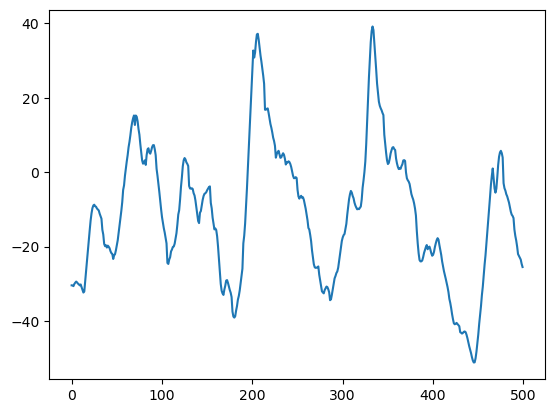

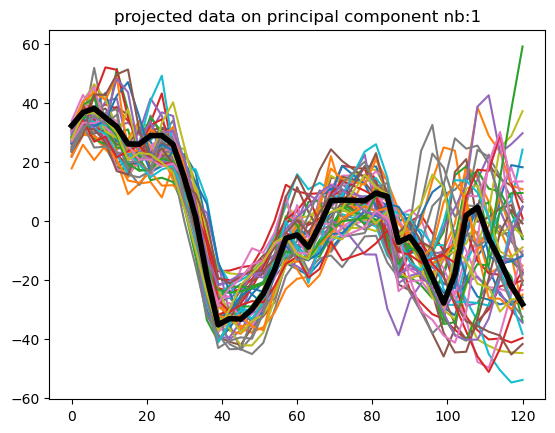

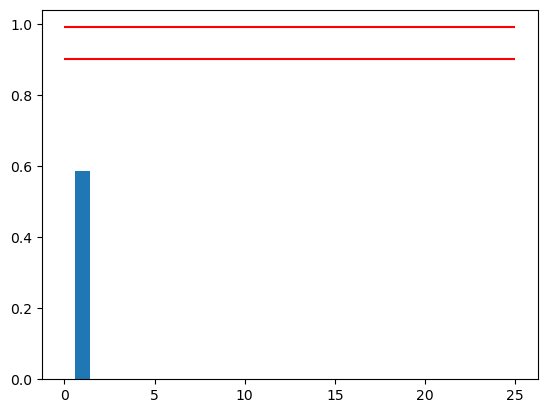

NameError: name 'norm' is not defined

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd


nPCAc = 1 
Y = dec_ws100[0,:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
pca = PCA(n_components=nPCAc)
principalComponents_ERA5 = pca.fit_transform(X)

plt.figure(0)
plt.plot(principalComponents_ERA5[:500,0])#,color='b')



Y = ws_ecmwf_cf_int[:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
principalComponents_cf = pca.transform(X)


PCarray = np.empty((len(step), 50, nPCAc))
PCarray[:,:,:] = 0.

for i in range(1,50):
    Y = ws_ecmwf_int[i,:,:,:]
    X = Y.reshape(Y.shape[0], -1)
    X = scaler.fit_transform(X)
    principalComponents = pca.transform(X)
    

    principalDf = pd.DataFrame(data = principalComponents, columns=list(range(1, nPCAc+1)))


#for loc0 in range(principalComponents.shape[1]):
    for j in range(0,nPCAc,1):
        plt.figure(j+2)
        plt.plot(step,principalComponents[:500,j])#,color='b')
        plt.title('PC nb:'+str(j+1))
        for k in range(len(step)):
            PCarray[k,i-1,j] = principalComponents[k,j] #nPCAc, nEns, step


for i in range(0,nPCAc,1):
    plt.figure(i+2)
    plt.plot(step,principalComponents_cf[:500,i],color='black',linewidth=4)
    plt.title('projected data on principal component nb:'+str(i+1))

plt.figure(6)
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 0.9,xmin= 0, xmax = 25,colors="red")
plt.hlines(y = 0.99,xmin= 0, xmax = 25,colors="red")
plt.show()


for i in range(0,1):

    mu_q, std_q = norm.fit(principalComponents_ERA5[:150000,i]) 
    plt.figure(3)
    plt.hist(principalComponents_ERA5[:150000,i], bins=25, density=True, alpha=0.6, color='b') 
    xmin, xmax = plt.xlim() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu_q, std_q) 
  
    plt.plot(x, p, 'k', linewidth=2) 
    title = "Fit Values: {:.2f} and {:.2f}".format(mu_q, std_q) 
    plt.title(title) 

plt.figure(5)
mu_p, std_p = norm.fit(PCarray[2,:,0])
plt.hist(PCarray[2,:,0],bins=10, density=True, alpha=0.6, color='b') #step, nEns, nPCAs
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu_p, std_p) 
plt.plot(x, p, 'k', linewidth=2) 
title = "Fit Values: {:.2f} and {:.2f}".format(mu_p, std_p) 
plt.title(title)




KeyboardInterrupt



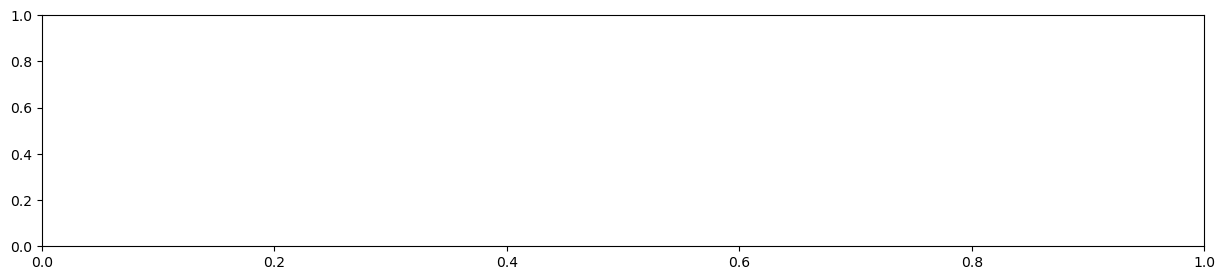

In [9]:
#PCarray:  #step, nEns, nPCAc
arr_mean = PCarray.mean(axis=1)
arr_std = PCarray.std(axis=1)


modenumber = list(range(nPCAc))


plt.figure(figsize=[15,3])
plt.contourf(arr_mean[:,:],np.arange(-40,41,1),cmap = 'RdBu',origin = 'lower')
plt.colorbar()
plt.xlabel('principal component number')
plt.ylabel('time [3h]')
plt.title('Behaviour of mean for ensemble')
plt.show()

plt.figure(figsize=[15,3])
plt.contourf(arr_std[:,:],np.arange(0,30,0.5),cmap = 'viridis',origin = 'lower')
plt.colorbar()
plt.xlabel('principal component number')
plt.ylabel('time [3h]')
plt.title('Behaviour of standard deviation for ensemble')
plt.show()


In [73]:
dispersion = 0.5*(np.log(std_q*std_q/(std_p*std_p)) + std_q*std_q/(std_p*std_p) - 1)
signal = 0.5* (mu_p - mu_q)*(mu_p - mu_q)/(std_q*std_q) 
print(dispersion)
print(signal)

R = dispersion + signal

print(R)

6.492039454239782
0.8817464024952949
7.3737858567350765


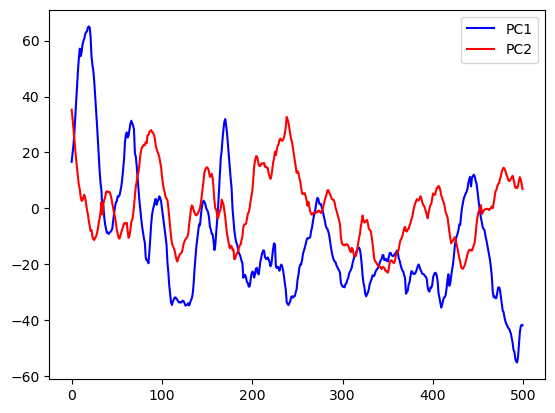

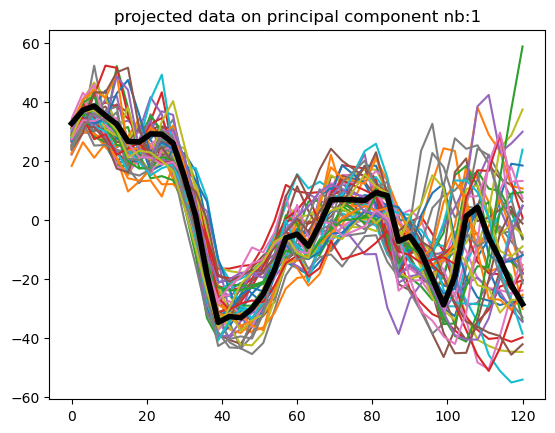

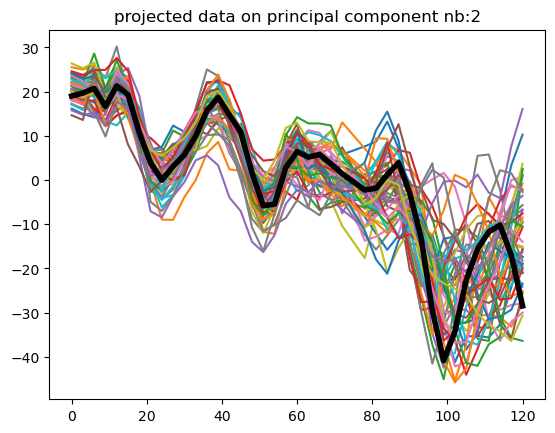

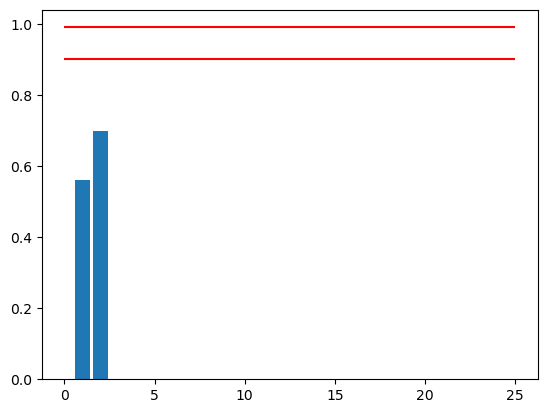

Text(0.5, 1.0, 'Fit Values: 19.92 and 4.66')

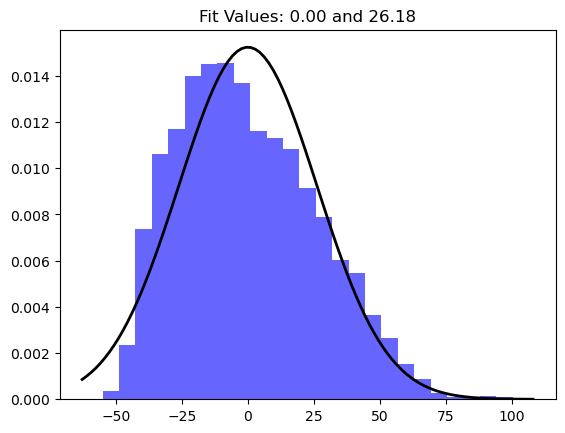

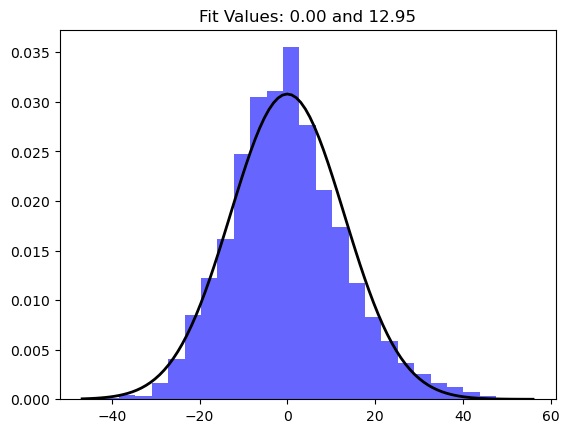

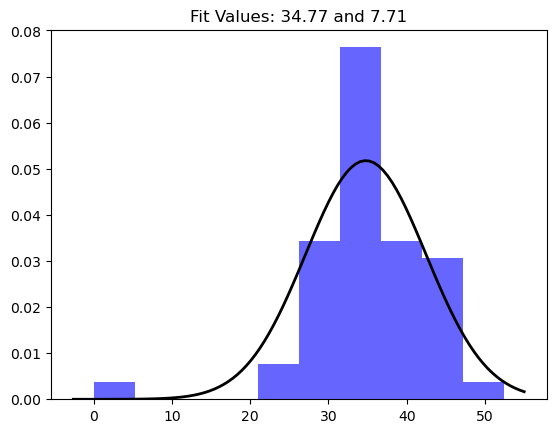

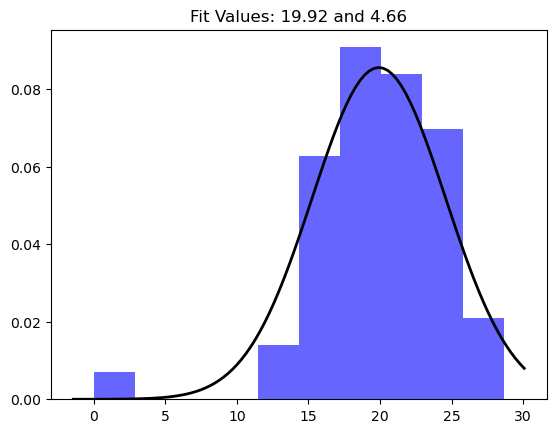

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd


nPCAc = 2 
Y = dec_ws100[0,:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
pca = PCA(n_components=nPCAc)
principalComponents_ERA5 = pca.fit_transform(X)

plt.figure(0)
plt.plot(principalComponents_ERA5[:500,0],color='b',label = 'PC1')
plt.plot(principalComponents_ERA5[:500,1],color='r',label='PC2')
plt.legend()



Y = ws_ecmwf_cf_int[:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
principalComponents_cf = pca.transform(X)


PCarray = np.empty((len(step), 50, nPCAc))
PCarray[:,:,:] = 0.

for i in range(1,50):
    Y = ws_ecmwf_int[i,:,:,:]
    X = Y.reshape(Y.shape[0], -1)
    X = scaler.fit_transform(X)
    principalComponents = pca.transform(X)
    

    principalDf = pd.DataFrame(data = principalComponents, columns=list(range(1, nPCAc+1)))


#for loc0 in range(principalComponents.shape[1]):
    for j in range(0,nPCAc,1):
        plt.figure(j+1)
        plt.plot(step,principalComponents[:500,j])#,color='b')
        plt.title('PC nb:'+str(j+1))
        for k in range(len(step)):
            PCarray[k,i-1,j] = principalComponents[k,j] #nPCAc, nEns, step


for i in range(0,nPCAc,1):
    plt.figure(i+1)
    plt.plot(step,principalComponents_cf[:500,i],color='black',linewidth=4)
    plt.title('projected data on principal component nb:'+str(i+1))

plt.figure(3)
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 0.9,xmin= 0, xmax = 25,colors="red")
plt.hlines(y = 0.99,xmin= 0, xmax = 25,colors="red")
plt.show()


for i in range(0,2):

    mu_q, std_q = norm.fit(principalComponents_ERA5[:150000,i]) 
    plt.figure(i+4)
    plt.hist(principalComponents_ERA5[:150000,i], bins=25, density=True, alpha=0.6, color='b') 
    xmin, xmax = plt.xlim() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu_q, std_q) 
  
    plt.plot(x, p, 'k', linewidth=2) 
    title = "Fit Values: {:.2f} and {:.2f}".format(mu_q, std_q) 
    plt.title(title) 

plt.figure(6)
mu_p1, std_p1 = norm.fit(PCarray[2,:,0])
plt.hist(PCarray[2,:,0],bins=10, density=True, alpha=0.6, color='b') #step, nEns, nPCAs
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu_p1, std_p1) 
plt.plot(x, p, 'k', linewidth=2) 
title = "Fit Values: {:.2f} and {:.2f}".format(mu_p1, std_p1) 
plt.title(title)

plt.figure(7)
mu_p2, std_p2 = norm.fit(PCarray[2,:,1])
plt.hist(PCarray[2,:,1],bins=10, density=True, alpha=0.6, color='b') #step, nEns, nPCAs
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu_p2, std_p2) 
plt.plot(x, p, 'k', linewidth=2) 
title = "Fit Values: {:.2f} and {:.2f}".format(mu_p2, std_p2) 
plt.title(title)



In [75]:
from scipy import stats

for i in range(len(step)):
    for j in range(nPCAc):
        res = stats.shapiro(PCarray[i,:,j])
        print('step:'+str(i))
        print('PCA component:'+str(j))
        print(res.statistic)

step:0
PCA component:0
0.729062557220459
step:0
PCA component:1
0.7688389420509338
step:1
PCA component:0
0.6612595915794373
step:1
PCA component:1
0.8036027550697327
step:2
PCA component:0
0.8752803802490234
step:2
PCA component:1
0.8995198011398315
step:3
PCA component:0
0.8615714907646179
step:3
PCA component:1
0.9129852056503296
step:4
PCA component:0
0.9370011687278748
step:4
PCA component:1
0.8734579086303711
step:5
PCA component:0
0.9409739971160889
step:5
PCA component:1
0.8689714074134827
step:6
PCA component:0
0.9332457780838013
step:6
PCA component:1
0.9866749048233032
step:7
PCA component:0
0.9673889875411987
step:7
PCA component:1
0.9542016386985779
step:8
PCA component:0
0.952316164970398
step:8
PCA component:1
0.9709013104438782
step:9
PCA component:0
0.9700855612754822
step:9
PCA component:1
0.9842020869255066
step:10
PCA component:0
0.9754664301872253
step:10
PCA component:1
0.9675610065460205
step:11
PCA component:0
0.9883843660354614
step:11
PCA component:1
0.9350878

Text(0, 0.5, 'relative entropy')

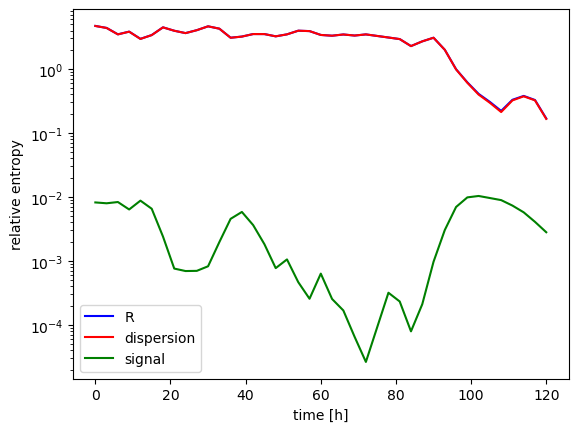

In [86]:
from scipy import stats

R_vec = []
disp_vec = []
sign_vec = []
for i in range(len(step)):
    # covarince matrix of q
    sigq = np.cov(principalComponents_ERA5[:150000,0],principalComponents_ERA5[:150000,1])
    # covariance matrix of p
    sigp = np.cov(PCarray[i,:,0],PCarray[i,:,1])    
    # vector of means of q
    meanq = np.array([np.mean(principalComponents_ERA5[:150000,0]),np.mean(principalComponents_ERA5[:150000,1])])
    # vector of means of p
    meanp = np.array([np.mean(PCarray[i,:,0]),np.mean(PCarray[i,:,1])])

    detsigp = np.linalg.det(sigp*sigp)
    detsigq = np.linalg.det(sigq*sigq)
    sigqinv = np.linalg.inv(sigq*sigq)

    dispersion = 0.5*(np.log(detsigq/detsigp) + np.trace(sigp*sigp/(sigq*sigq)) - 2)
    signal = 0.5*(np.dot(meanp-meanq,np.dot(sigqinv,meanp-meanq)))
  

    R = dispersion + signal

    R_vec.append(R)
    disp_vec.append(dispersion)
    sign_vec.append(signal)

plt.plot(step,R_vec,color='b',label='R')
plt.plot(step,disp_vec,color='r',label='dispersion')
plt.plot(step,sign_vec,color='g',label='signal')
plt.legend()
plt.yscale('log')
plt.xlabel('time [h]')
plt.ylabel('relative entropy')



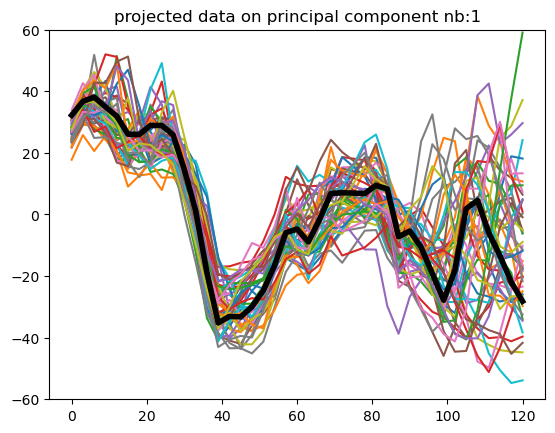

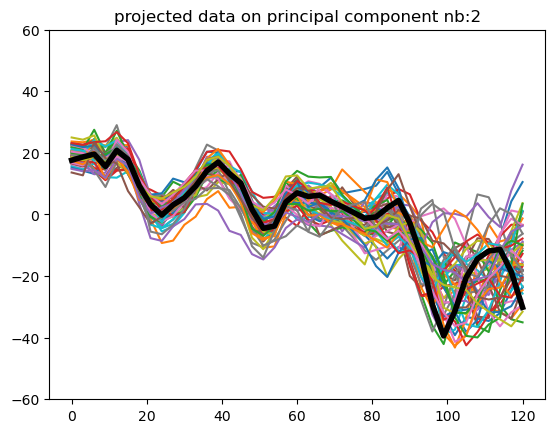

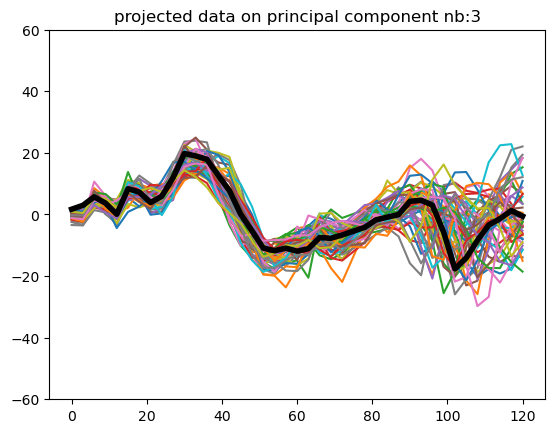

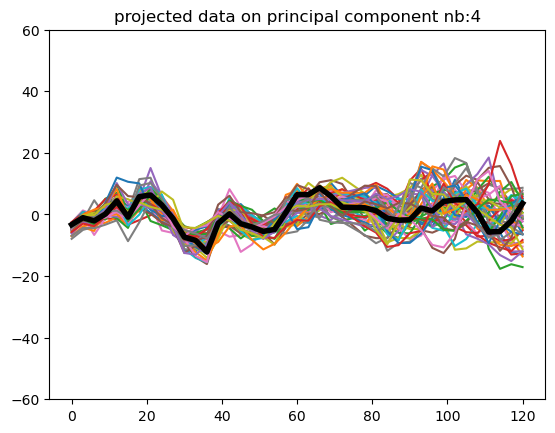

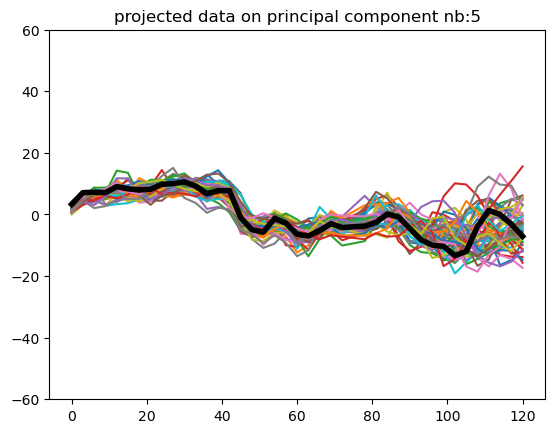

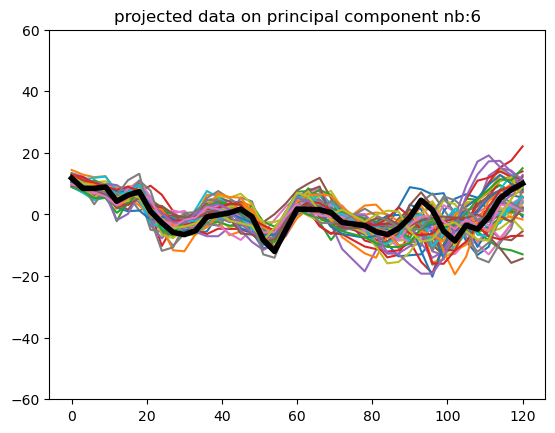

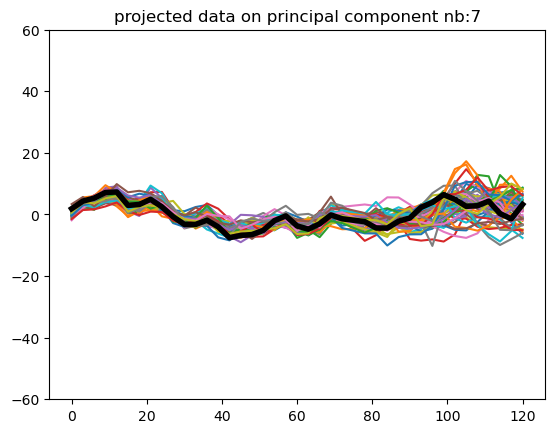

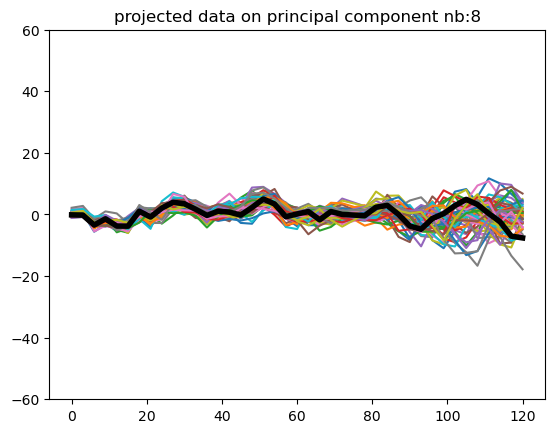

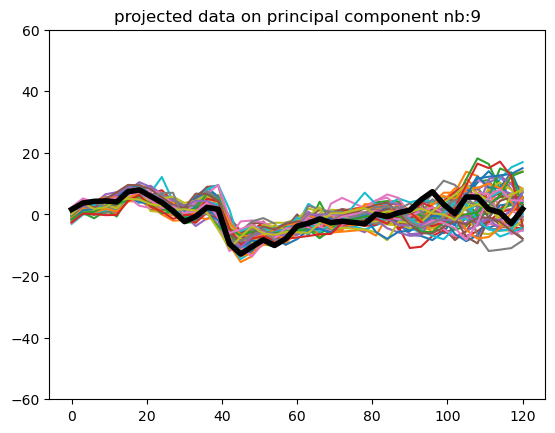

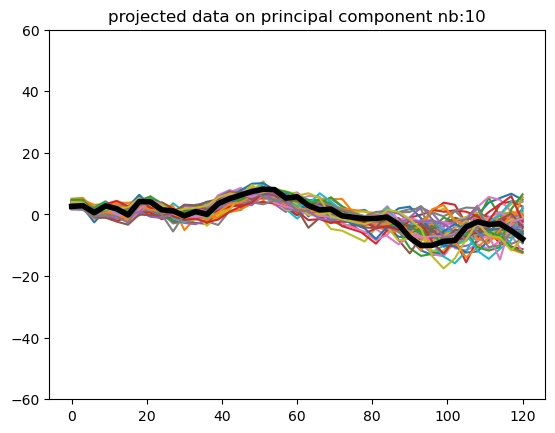

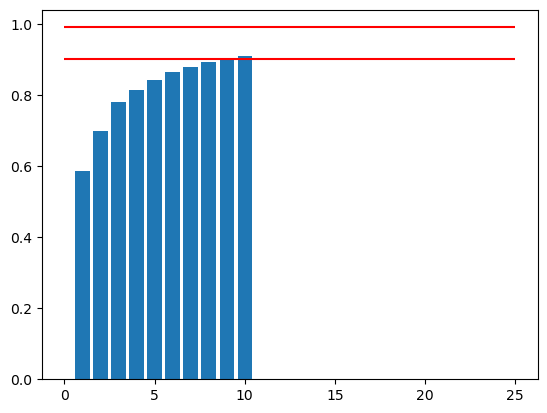

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd


nPCAc = 10
Y = dec_ws100[0,:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
pca = PCA(n_components=nPCAc)
principalComponents_ERA5 = pca.fit_transform(X)

#plt.figure(0)
#for i in range(nPCAc):  
#    plt.plot(principalComponents_ERA5[:150000,i],label = 'PC'+str(i+1))
#plt.legend()



Y = ws_ecmwf_cf_int[:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
principalComponents_cf = pca.transform(X)

PCarray = np.empty((len(step), 50, nPCAc))
PCarray[:,:,:] = 0.


for i in range(1,50):
    Y = ws_ecmwf_int[i,:,:,:]
    X = Y.reshape(Y.shape[0], -1)
    X = scaler.fit_transform(X)
    principalComponents = pca.transform(X)
    

    principalDf = pd.DataFrame(data = principalComponents, columns=list(range(1, nPCAc+1)))


#for loc0 in range(principalComponents.shape[1]):
    for j in range(0,nPCAc,1):
        plt.figure(j+1)
        plt.plot(step,principalComponents[:500,j])#,color='b')
        plt.title('PC nb:'+str(j+1))
        for k in range(len(step)):
            PCarray[k,i-1,j] = principalComponents[k,j] #step, nEns, nPCAs


for i in range(0,nPCAc,1):
    plt.figure(i+1)
    plt.title('PC nb:'+str(i+1))
    plt.plot(step,principalComponents_cf[:500,i],color='black',linewidth=4)
    plt.ylim([-60,60])
    plt.title('projected data on principal component nb:'+str(i+1))

plt.figure(nPCAc+1)
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 0.9,xmin= 0, xmax = 25,colors="red")
plt.hlines(y = 0.99,xmin= 0, xmax = 25,colors="red")
plt.show()


#for i in range(0,2):

#    mu_q, std_q = norm.fit(principalComponents_ERA5[:150000,i]) 
#    plt.figure(i+4)
#    plt.hist(principalComponents_ERA5[:150000,i], bins=25, density=True, alpha=0.6, color='b') 
#    xmin, xmax = plt.xlim() 
#    x = np.linspace(xmin, xmax, 100) 
#    p = norm.pdf(x, mu_q, std_q) 
#  
##    plt.plot(x, p, 'k', linewidth=2) 
#    title = "Fit Values: {:.2f} and {:.2f}".format(mu_q, std_q) 
#    plt.title(title) 

#plt.figure(6)
#mu_p1, std_p1 = norm.fit(PCarray[2,:,0])
#plt.hist(PCarray[2,:,0],bins=10, density=True, alpha=0.6, color='b') #step, nEns, nPCAs
#xmin, xmax = plt.xlim() 
#x = np.linspace(xmin, xmax, 100) 
#p = norm.pdf(x, mu_p1, std_p1) 
#plt.plot(x, p, 'k', linewidth=2) 
#title = "Fit Values: {:.2f} and {:.2f}".format(mu_p1, std_p1) 
#plt.title(title)





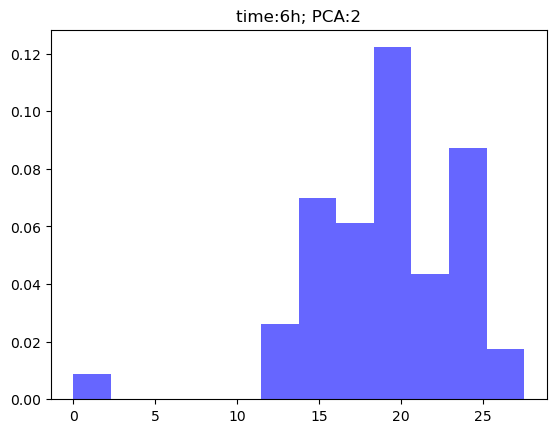

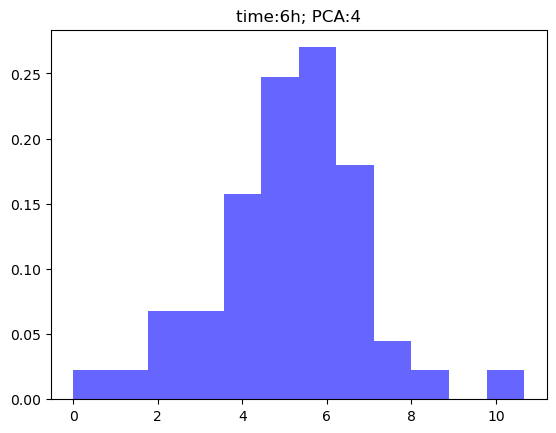

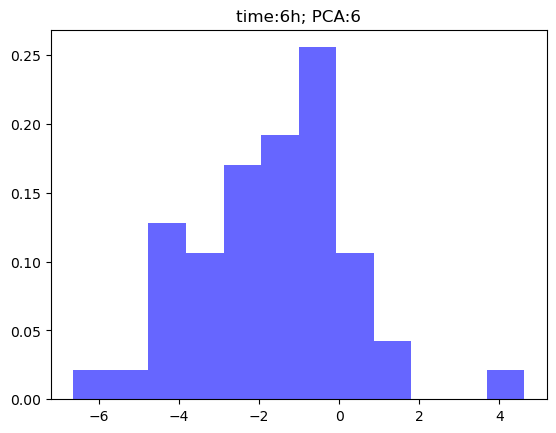

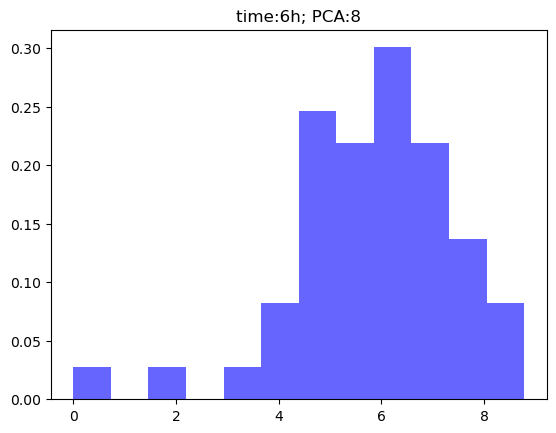

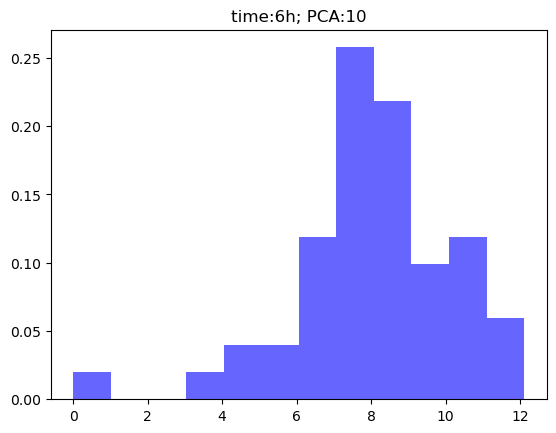

In [57]:
tstep = 2
bins = 12
plt.figure(nPCAc+2)
plt.hist(PCarray[tstep,:,1],bins=bins, density=True, alpha=0.6, color='b')
plt.title('time:'+str(step[tstep])+'h; PCA:'+str(2))
plt.show()

plt.figure(nPCAc+2)
plt.hist(PCarray[tstep,:,2],bins=bins, density=True, alpha=0.6, color='b')
plt.title('time:'+str(step[tstep])+'h; PCA:'+str(4))
plt.show()

plt.figure(nPCAc+2)
plt.hist(PCarray[tstep,:,3],bins=bins, density=True, alpha=0.6, color='b')
plt.title('time:'+str(step[tstep])+'h; PCA:'+str(6))
plt.show()

plt.figure(nPCAc+2)
plt.hist(PCarray[tstep,:,4],bins=bins, density=True, alpha=0.6, color='b')
plt.title('time:'+str(step[tstep])+'h; PCA:'+str(8))
plt.show()

plt.figure(nPCAc+2)
plt.hist(PCarray[tstep,:,5],bins=bins, density=True, alpha=0.6, color='b')
plt.title('time:'+str(step[tstep])+'h; PCA:'+str(10))
plt.show()

Text(0, 0.5, 'relative entropy')

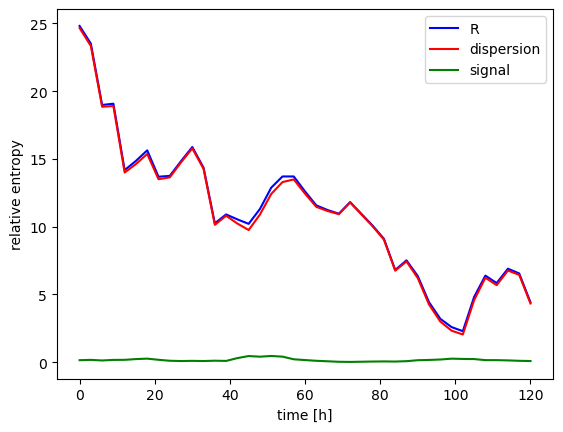

In [58]:
R_vec = []
disp_vec = []
sign_vec = []


for i in range(len(step)):
    meanq = []
    meanp = []  
    # covariance matrix of p
    bla = PCarray[i,:,0]
    for j in range(1,nPCAc):
        bla = np.vstack([bla, PCarray[i,:,j]])
    sigp = np.cov(bla)  
    # covarince matrix of q
    bla = principalComponents_ERA5[:150000,0]
    for j in range(1,nPCAc):
        bla = np.vstack([bla, principalComponents_ERA5[:150000,j]])       
    sigq = np.cov(bla)

    for j in range(0,nPCAc):
        meanp.append(np.mean(PCarray[i,:,j]))
        meanq.append(np.mean(principalComponents_ERA5[:150000,j]))
    # vector of means of q
    meanq = np.array(meanq)
    # vector of means of p
    meanp = np.array(meanp)

    detsigp = np.linalg.det(sigp*sigp)
    detsigq = np.linalg.det(sigq*sigq)
    sigqinv = np.linalg.inv(sigq*sigq)

    dispersion = 0.5*(np.log(detsigq/detsigp) + np.trace(sigp*sigp/(sigq*sigq)) - nPCAc)
    signal_help = np.dot(sigqinv,meanp-meanq)
    signal = 0.5*(np.dot(meanp-meanq,signal_help))

    R = dispersion + signal

    R_vec.append(R)
    disp_vec.append(dispersion)
    sign_vec.append(signal)

plt.plot(step,R_vec,color='b',label='R')
plt.plot(step,disp_vec,color='r',label='dispersion')#
plt.plot(step,sign_vec,color='g',label='signal')
plt.legend()
#plt.yscale('log')
plt.xlabel('time [h]')
plt.ylabel('relative entropy')

# ENTSOE Data

In [61]:
import os
from entsoe import EntsoePandasClient
import pandas as pd
import datetime as dt
import pytz
from dateutil.relativedelta import *
from matplotlib import pyplot as plt
from rivapy import user_settings

ImportError: cannot import name 'user_settings' from 'rivapy' (C:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\rivapy\__init__.py)